### AFSIS Soil Properties Competition Overview

**Objective**:  
The [AFSIS Soil Properties competition](https://www.kaggle.com/competitions/afsis-soil-properties/overview) focuses on predicting various soil properties using spectral data. These properties are vital for assessing soil health, which in turn influences agricultural practices and environmental management.

**Data**:  
Two main datasets are provided for this competition:
- **Training Data**: This dataset includes spectral data alongside the corresponding soil property values, allowing for the model to be trained on these features.
- **Test Data**: This dataset contains spectral data without the associated soil property values. The objective is to use the trained model to predict these values for the test dataset.

**Evaluation Metric**:  
The competition's performance is evaluated using the Root Mean Squared Error (RMSE). The goal for participants is to develop models that minimise the RMSE across the predicted soil properties, ensuring high accuracy in the predictions.

You can find more information and access the data [here](https://www.kaggle.com/competitions/afsis-soil-properties/data).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge  # Simpler estimator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA  # For feature reduction
from sklearn.pipeline import Pipeline

# Load the datasets
train_data = pd.read_csv(r"C:\Users\Abba Emmanuel\Downloads\Tcode\training.csv")
test_data = pd.read_csv(r"C:\Users\Abba Emmanuel\Downloads\Tcode\sorted_test.csv")

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Columns: 3600 entries, PIDN to Sand
dtypes: float64(3598), object(2)
memory usage: 31.8+ MB


In [3]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Columns: 3595 entries, PIDN to Depth
dtypes: float64(3593), object(2)
memory usage: 19.9+ MB


In [4]:
train_data.describe()

,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,m7480.61,...,REF3,REF7,RELI,TMAP,TMFI,Ca,P,pH,SOC,Sand
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,...,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000
mean,0.245666,0.240454,0.235631,0.238994,0.248176,0.251674,0.243996,0.235162,0.232874,0.232518,...,-0.661642,-0.638464,0.276786,0.563194,0.746303,0.006442,-0.014524,-0.028543,0.080414,-0.012646
std,0.114439,0.114804,0.115288,0.115075,0.114185,0.113603,0.113974,0.114723,0.115031,0.115021,...,0.365572,0.326460,1.074667,0.649622,0.825242,1.070541,0.995469,0.920224,1.141989,0.988520
min,-0.042260,-0.048559,-0.055518,-0.052353,-0.040608,-0.034516,-0.042619,-0.053856,-0.057699,-0.058482,...,-1.265010,-1.115423,-0.639823,-0.670742,-0.862741,-0.535828,-0.418309,-1.886946,-0.857863,-1.493378
25%,0.171156,0.166020,0.161043,0.164470,0.173065,0.175476,0.169058,0.161094,0.159238,0.158868,...,-0.917184,-0.881048,-0.452939,0.190708,0.056843,-0.451077,-0.345681,-0.717841,-0.615639,-0.899649
50%,0.252899,0.247918,0.244594,0.247920,0.255784,0.258029,0.251061,0.243775,0.241991,0.241599,...,-0.753623,-0.740423,-0.130139,0.316667,0.729111,-0.348682,-0.269595,-0.175376,-0.349974,-0.134651
75%,0.315508,0.310354,0.304742,0.309540,0.317786,0.320834,0.314091,0.304301,0.303235,0.302438,...,-0.445135,-0.432460,0.532450,0.955935,1.414215,-0.042654,-0.089755,0.376442,0.275121,0.786391
max,0.730793,0.725493,0.720711,0.723293,0.731205,0.733872,0.726075,0.717652,0.716443,0.716307,...,0.366460,0.290323,5.612300,2.161892,2.976315,9.645815,13.266841,3.416117,7.619989,2.251685


In [5]:
test_data.describe()

,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,m7480.61,...,EVI,LSTD,LSTN,REF1,REF2,REF3,REF7,RELI,TMAP,TMFI
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,...,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,0.232165,0.226979,0.222080,0.225511,0.234976,0.238725,0.231077,0.222129,0.219685,0.219343,...,0.583861,-0.364974,0.269816,-0.668341,-0.572728,-0.594943,-0.640463,0.084040,0.545331,0.703120
std,0.098487,0.099179,0.099853,0.099608,0.098558,0.097966,0.098652,0.099714,0.099947,0.099900,...,0.727844,0.835115,0.883666,0.320982,0.350492,0.410649,0.364303,0.941628,0.682021,0.787634
min,-0.037277,-0.043984,-0.050737,-0.046731,-0.034096,-0.028093,-0.037383,-0.049268,-0.052309,-0.052265,...,-0.800292,-2.366282,-1.760197,-1.161455,-1.360853,-1.267081,-1.268649,-0.605844,-0.541529,-0.772670
25%,0.170926,0.165406,0.160249,0.163639,0.173564,0.177973,0.169524,0.160199,0.157819,0.157650,...,0.164723,-1.046907,-0.546596,-0.885818,-0.792208,-0.910973,-0.929435,-0.401971,-0.021042,0.182431
50%,0.246999,0.242504,0.239130,0.241215,0.249651,0.253969,0.245869,0.238573,0.236578,0.236108,...,0.507289,-0.390770,0.497065,-0.746909,-0.614100,-0.672878,-0.684476,-0.266055,0.501829,0.774477
75%,0.294929,0.290607,0.287255,0.290548,0.299234,0.301754,0.294658,0.286204,0.284108,0.283883,...,1.043003,0.261494,1.042551,-0.547273,-0.439703,-0.378882,-0.412550,0.124703,0.981483,1.053572
max,0.490711,0.486155,0.482087,0.485504,0.494250,0.497684,0.490965,0.483429,0.481667,0.481884,...,2.201895,1.666615,1.844185,0.572364,0.530612,0.681159,0.579637,5.731226,2.180246,2.622005


**Feature Analysis**

*3.1 Examine Spectral Data Distribution*

In [6]:
# Summary Statistic

spectral_columns = train_data.columns.difference(['sample_id', 'Ca', 'P', 'pH', 'SOC', 'Sand'])
spectral_summary = train_data[spectral_columns].describe()
print(spectral_summary)

              BSAN         BSAS         BSAV          CTI         ELEV  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean     -0.572226    -0.623242    -0.691976    -0.213203     0.533953   
std       0.235748     0.239737     0.281652     0.661576     1.396132   
min      -1.007246    -0.972727    -1.175812    -0.945472    -1.326726   
25%      -0.739130    -0.781818    -0.895857    -0.548063    -0.812249   
50%      -0.608696    -0.681818    -0.761478    -0.344714     0.867038   
75%      -0.463768    -0.563636    -0.604703    -0.104917     1.292428   
max       0.217391     0.200000     0.223964     3.596526     4.891537   

               EVI         LSTD         LSTN         REF1         REF2  ...  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000  ...   
mean      0.698859    -0.413636    -0.092569    -0.698528    -0.506340  ...   
std       0.683280     0.686773     0.861165     0.272107     0.329785  ...   
min      -0.88192

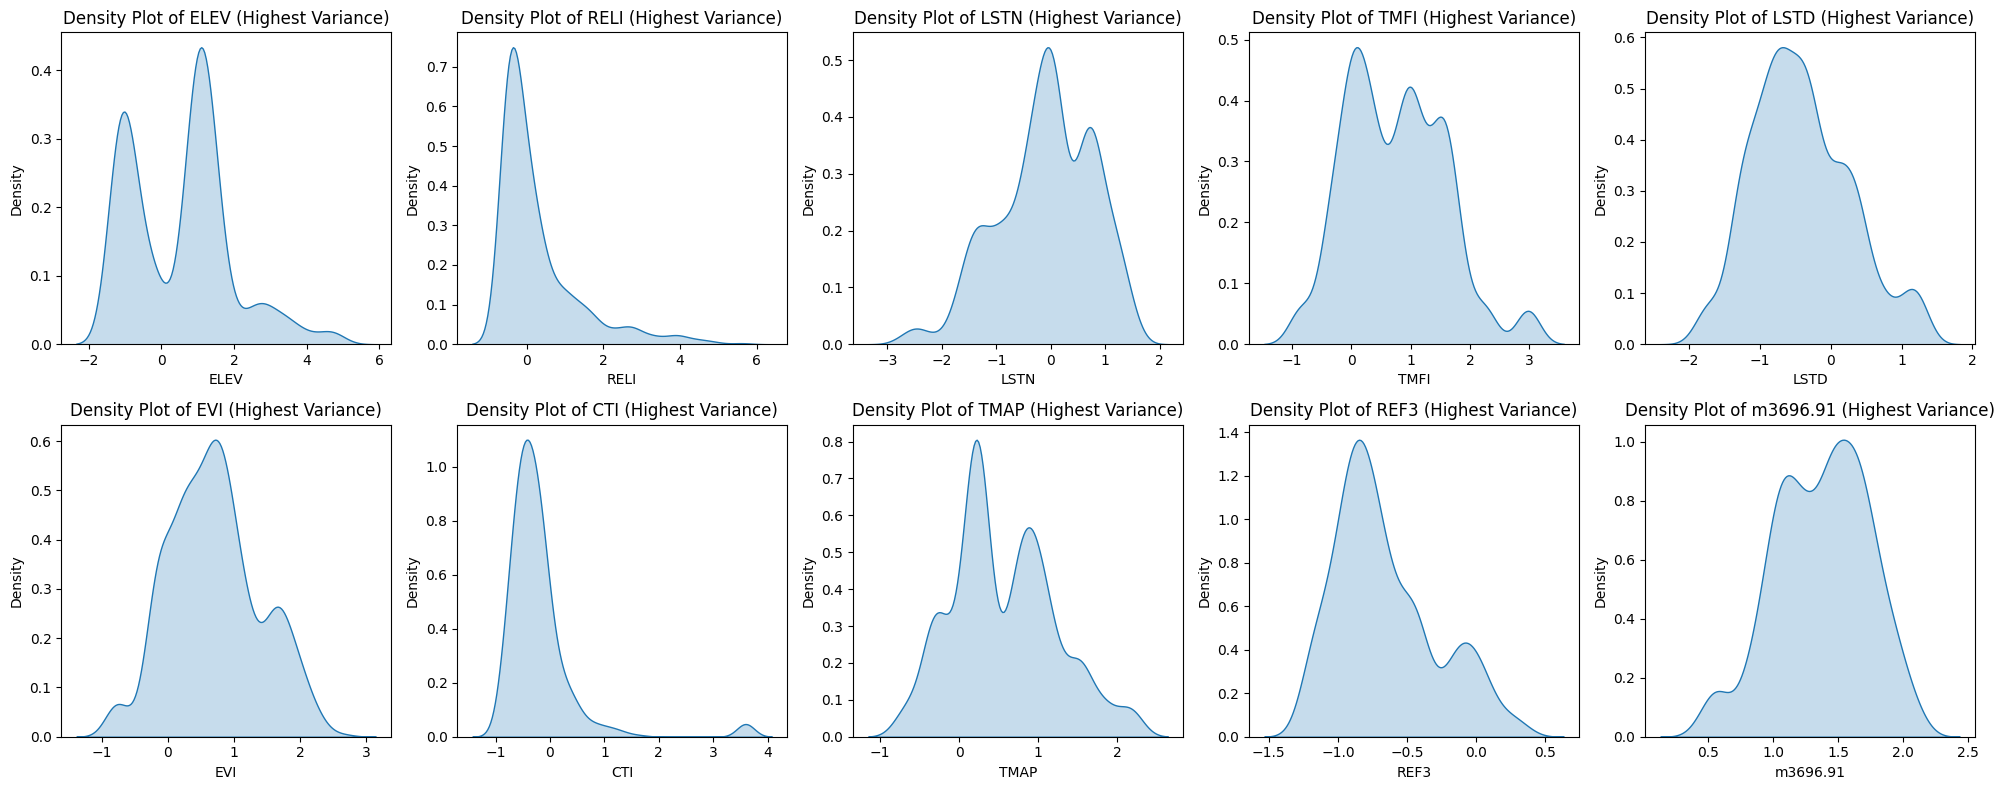

In [7]:
# Density plot Using Columns with the Highest Variance
# Ensure that only numeric columns are selected
numeric_spectral_columns = train_data[spectral_columns].select_dtypes(include=['number'])

# Calculate variance for each numeric column
variances = numeric_spectral_columns.var()

# Select the top 10 columns with the highest variance
top_variance_columns = variances.nlargest(10).index

# Set up the subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot each selected column in a subplot
for i, col in enumerate(top_variance_columns):
    ax = axes[i // 5, i % 5]
    sns.kdeplot(train_data[col], fill=True, ax=ax)
    ax.set_title(f'Density Plot of {col} (Highest Variance)')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


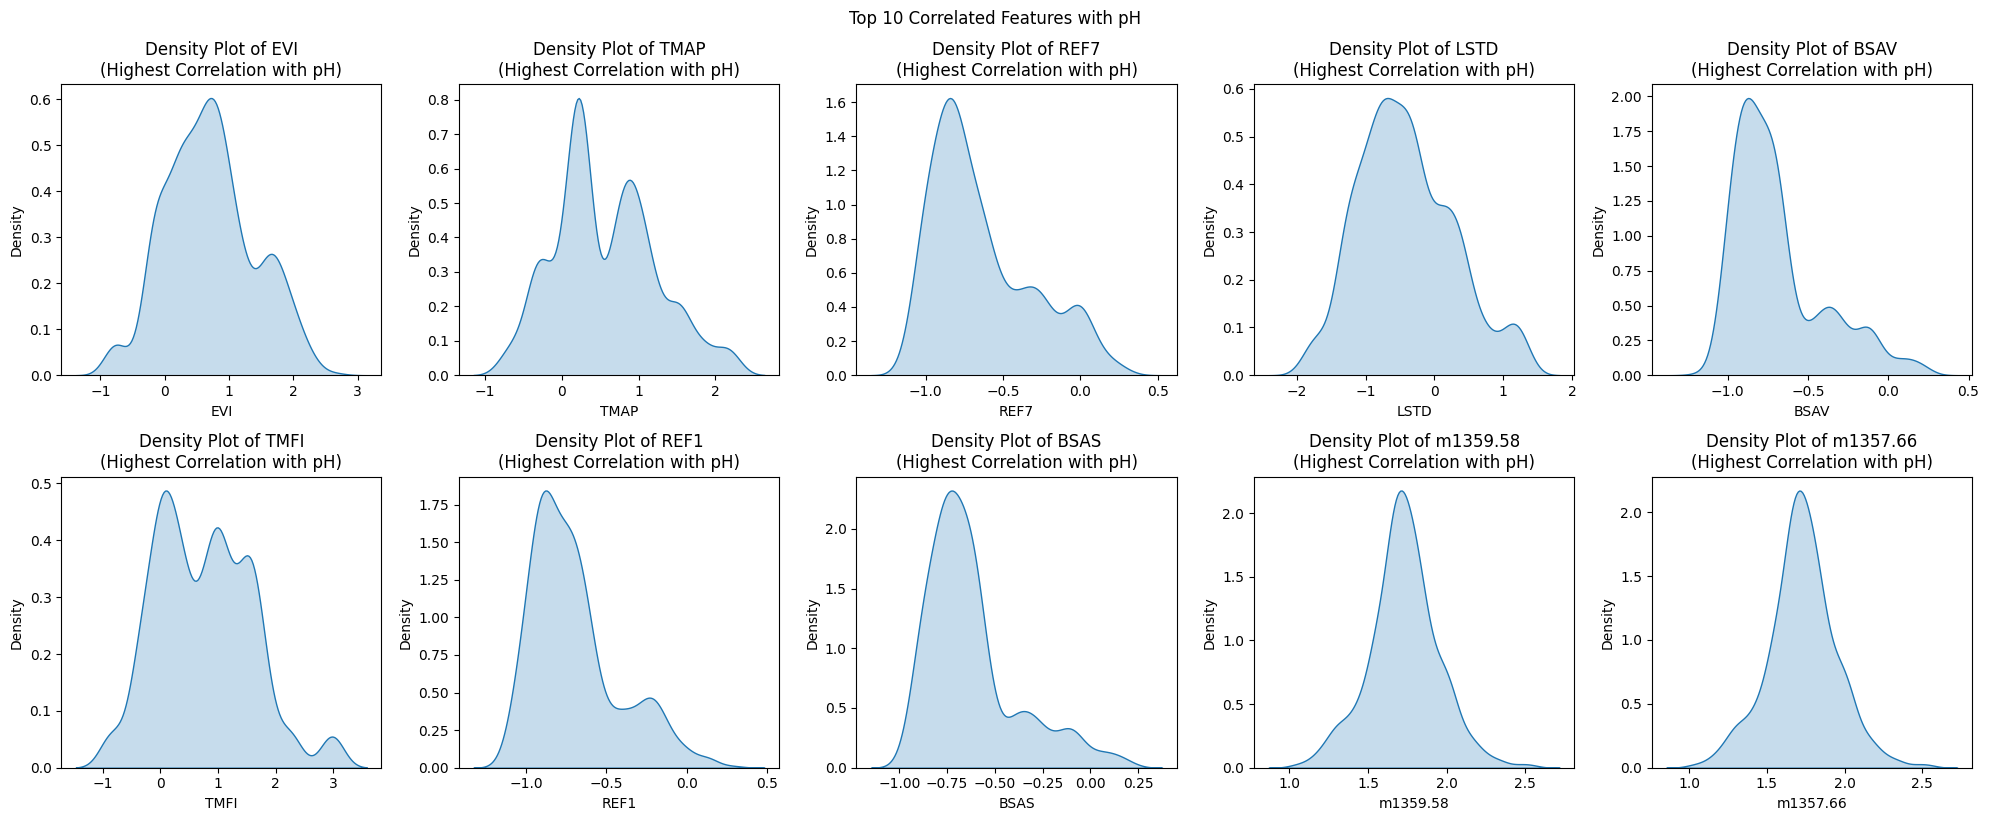

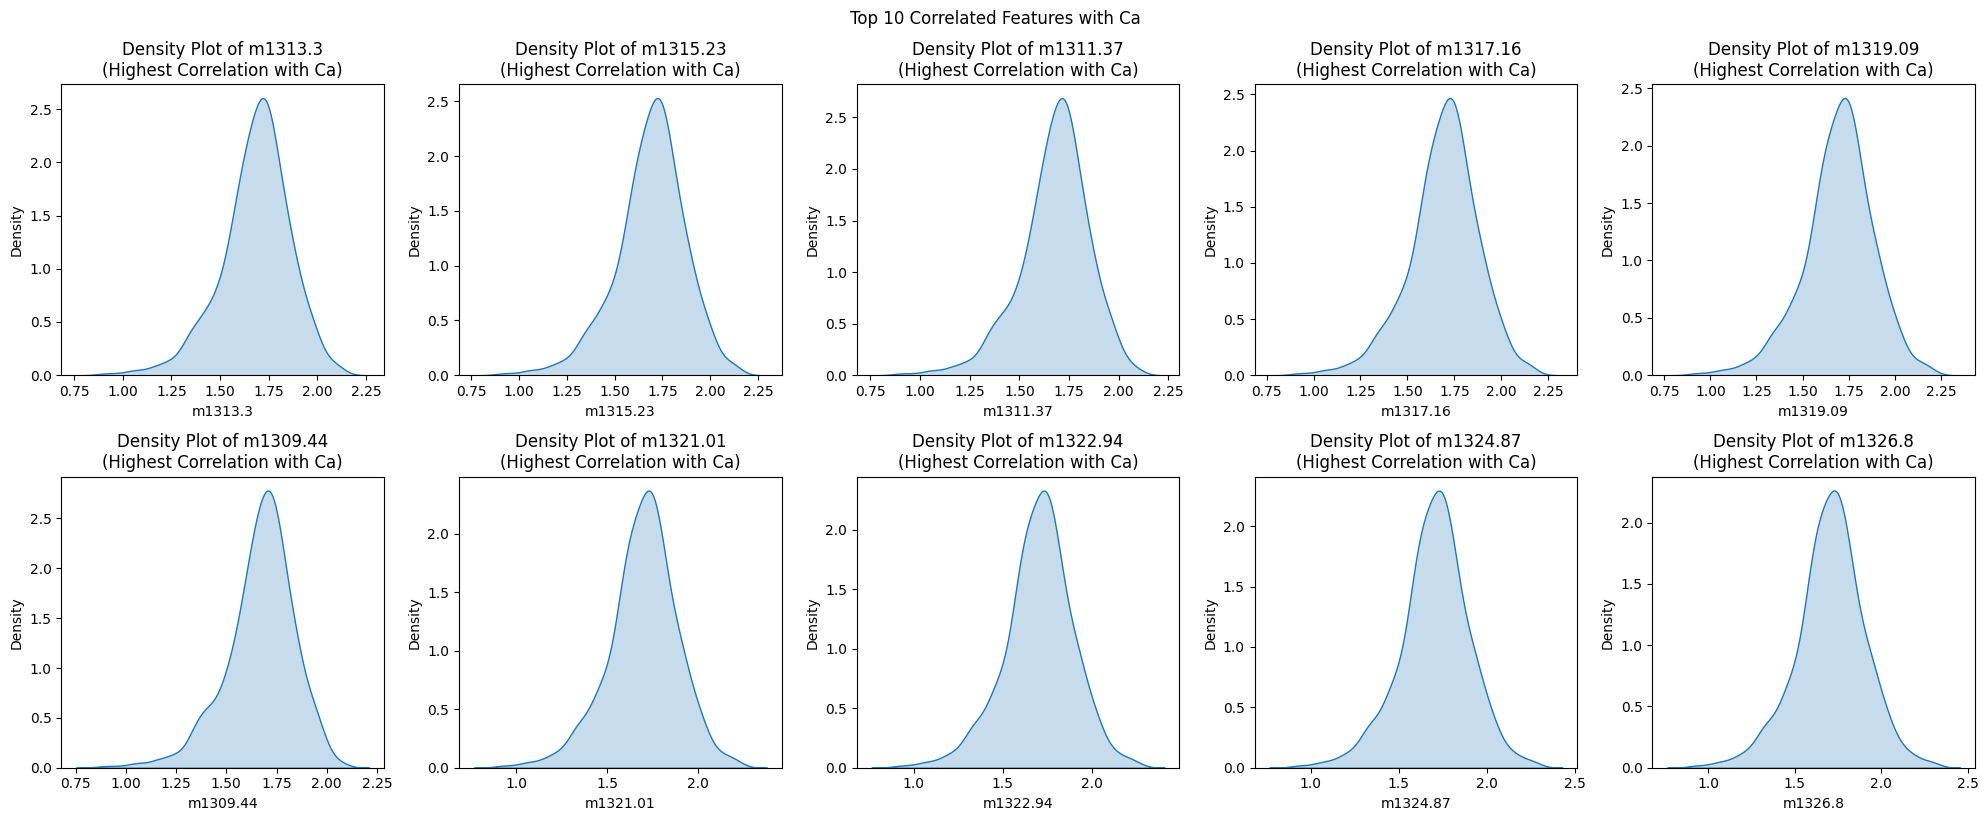

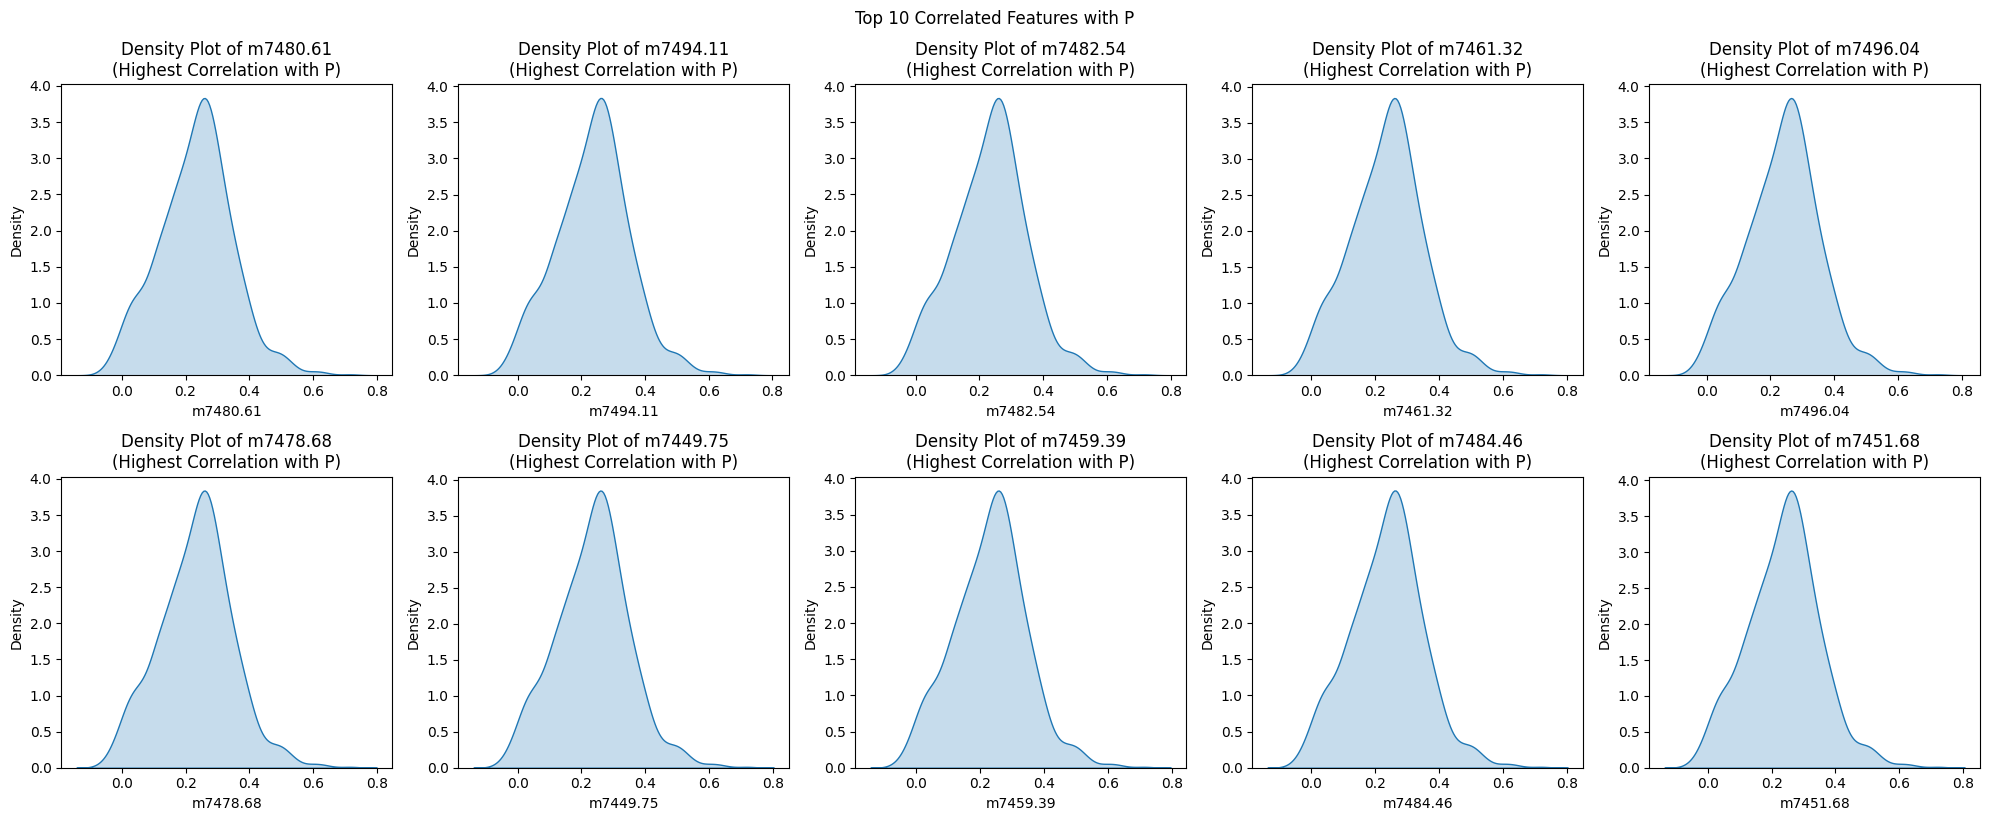

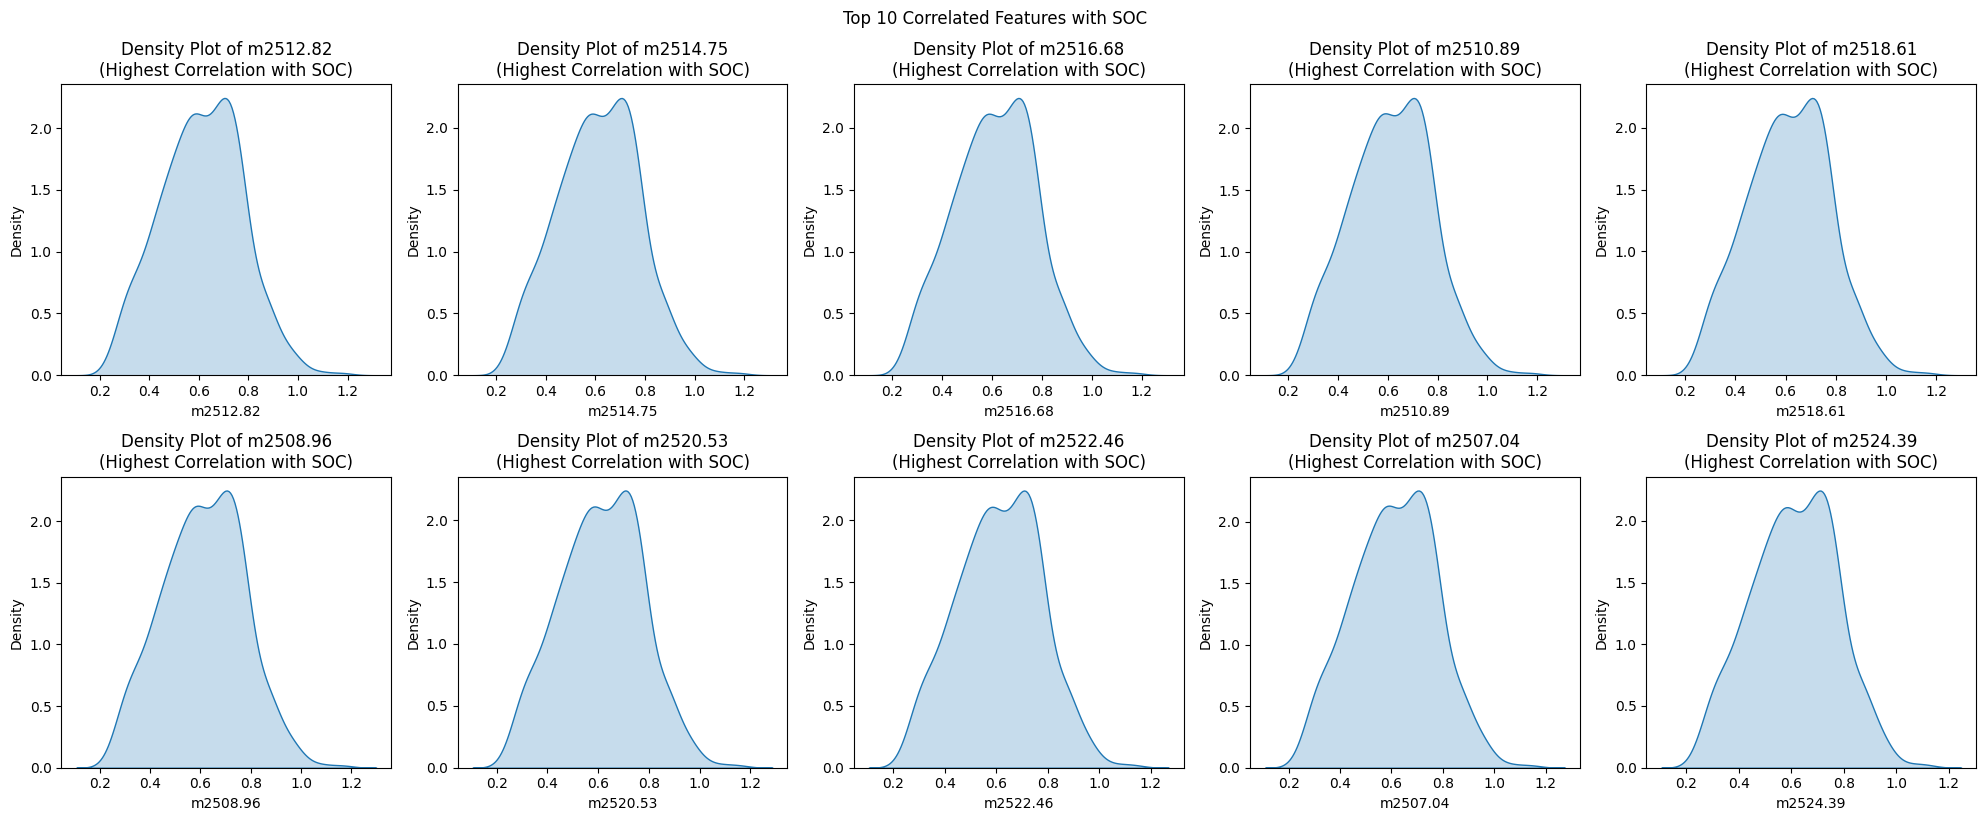

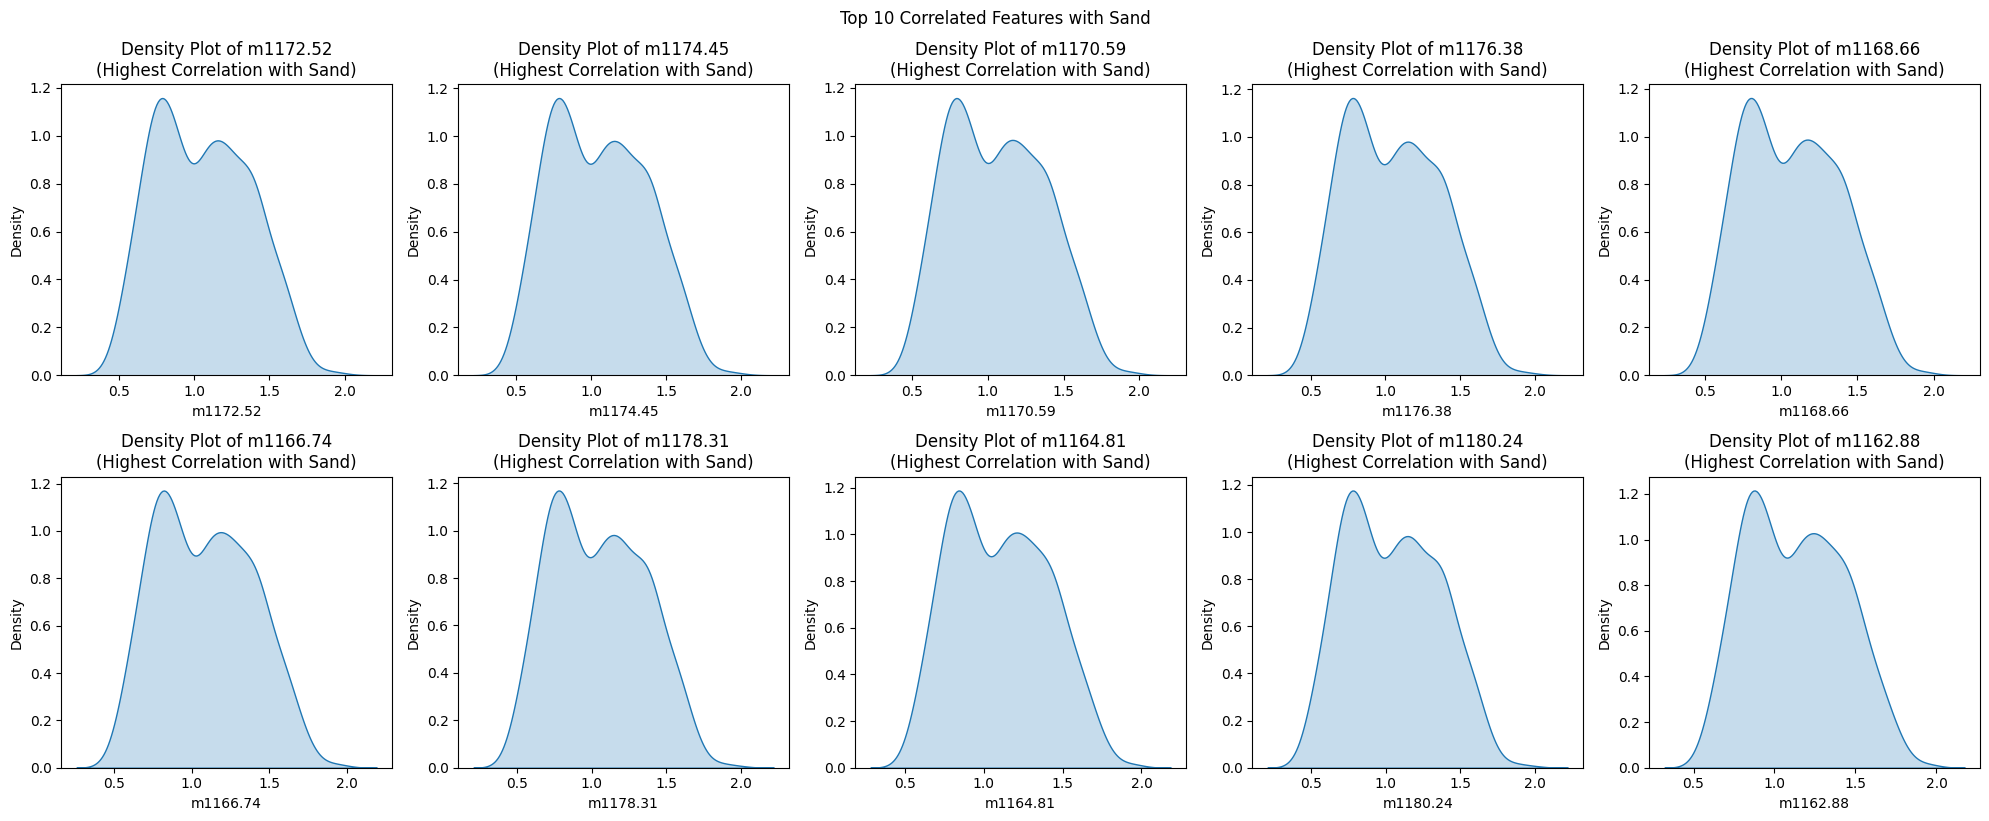

In [8]:
# Assuming 'train_data' and 'spectral_columns' are already defined
target_columns = ['pH', 'Ca', 'P', 'SOC', 'Sand']

# Convert target columns to numeric, forcing errors to NaN
for target_column in target_columns:
    train_data[target_column] = pd.to_numeric(train_data[target_column], errors='coerce')

# Drop rows where any of the target columns have NaN values
train_data = train_data.dropna(subset=target_columns)

# Identify and exclude non-numeric spectral columns
numeric_spectral_columns = train_data[spectral_columns].select_dtypes(include=[np.number]).columns

# Initialize a dictionary to store the top correlated columns for each target
top_correlated_columns_dict = {}

# Loop through each target column
for target_column in target_columns:
    # Calculate correlation with the target variable using only numeric spectral columns
    correlations = train_data[numeric_spectral_columns].corrwith(train_data[target_column]).abs()
    
    # Select the top 10 most correlated columns
    top_correlated_columns = correlations.nlargest(10).index
    
    # Store the top columns in the dictionary
    top_correlated_columns_dict[target_column] = top_correlated_columns

# Loop through each target column and its top correlated columns
for target_column, top_correlated_columns in top_correlated_columns_dict.items():
    # Set up the subplot grid (2 rows, 5 columns)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Plot each selected column in a subplot
    for i, col in enumerate(top_correlated_columns):
        ax = axes[i // 5, i % 5]
        sns.kdeplot(train_data[col], fill=True, ax=ax)
        ax.set_title(f'Density Plot of {col}\n(Highest Correlation with {target_column})')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
    
    plt.tight_layout()
    plt.suptitle(f'Top 10 Correlated Features with {target_column}', y=1.02)
    plt.show()


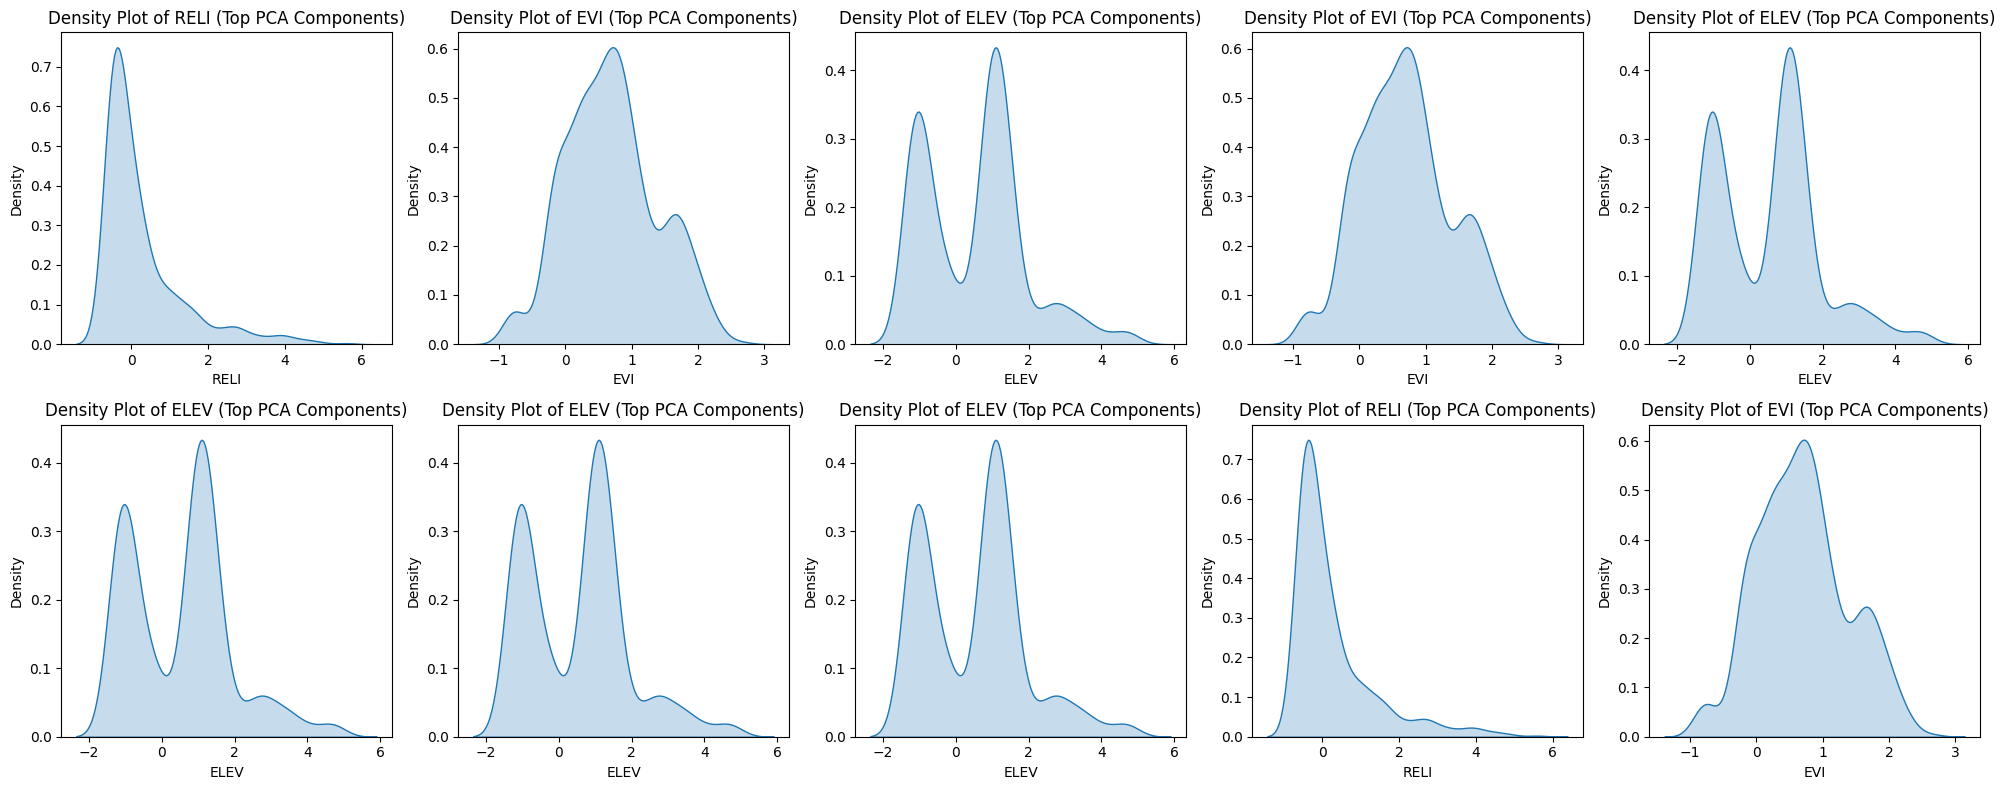

In [9]:
# Density Plot Using Columns Most Representative of the Dataset (using PCA)
# Apply PCA to the data
# Apply PCA to the numeric spectral data
pca = PCA(n_components=10)
pca.fit(train_data[numeric_spectral_columns])

# Get the top contributing columns for each principal component
pca_columns = np.abs(pca.components_).argmax(axis=1)
selected_columns = train_data[numeric_spectral_columns].columns[pca_columns]

# Set up the subplot grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot each selected column in a subplot
for i, col in enumerate(selected_columns):
    ax = axes[i // 5, i % 5]
    sns.kdeplot(train_data[col], fill=True, ax=ax)
    ax.set_title(f'Density Plot of {col} (Top PCA Components)')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


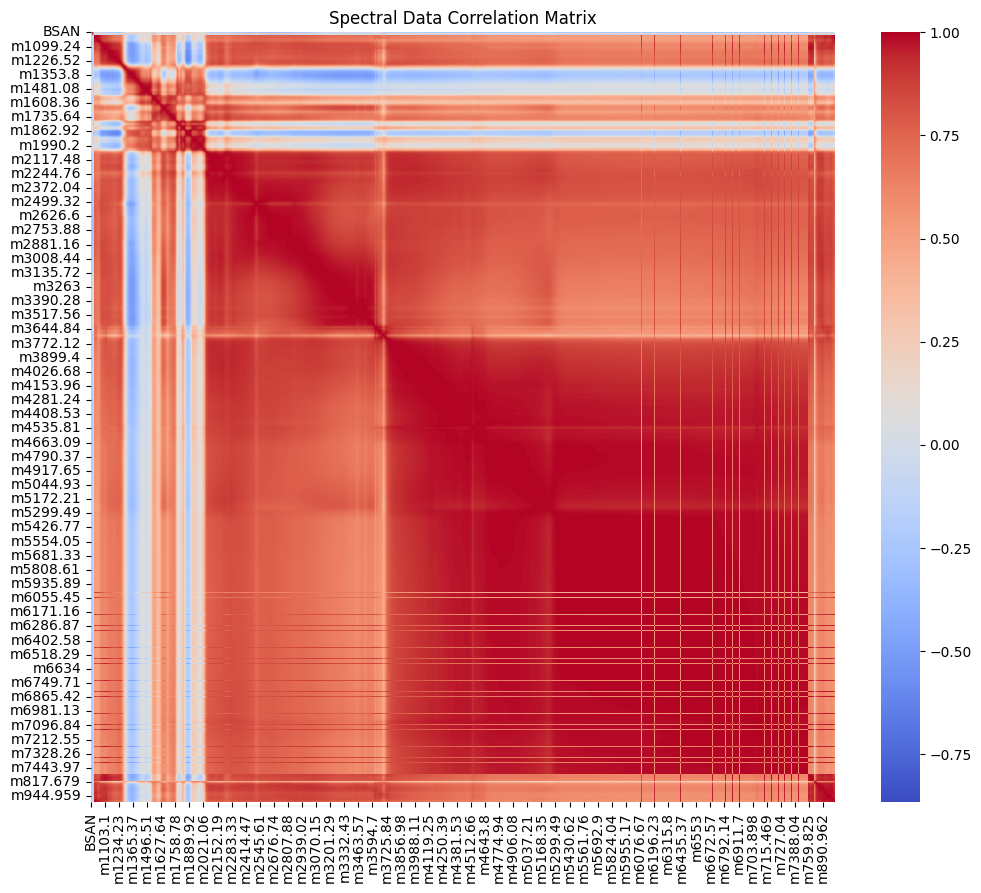

In [10]:
# Correlation Analysis

# Select only numeric spectral columns
numeric_spectral_columns = train_data[spectral_columns].select_dtypes(include=[np.number]).columns

# Compute the correlation matrix using only numeric columns
correlation_matrix = train_data[numeric_spectral_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Spectral Data Correlation Matrix')
plt.show()


*3.2 Identify Target Soil Properties*

In [11]:
# Relationship with Spectral Data
# Filter out columns in spectral_columns that don't exist in train_data
valid_spectral_columns = [col for col in spectral_columns if col in train_data.columns]

# Ensure that the data in the spectral columns is numeric
train_data[valid_spectral_columns] = train_data[valid_spectral_columns].apply(pd.to_numeric, errors='coerce')

# Relationship with Spectral Data
for target in target_columns:
    if target in train_data.columns:
        # Combine spectral columns and target column
        relevant_data = train_data[valid_spectral_columns + [target]].dropna()
        
        # Calculate the correlation with valid spectral columns
        target_correlation = relevant_data.corr()[target].sort_values(ascending=False)
        
        print(f'Correlation of spectral features with {target}:')
        print(target_correlation)
    else:
        print(f"Target {target} is not present in the DataFrame.")


Correlation of spectral features with pH:
BSAN       NaN
BSAS       NaN
BSAV       NaN
CTI        NaN
Depth      NaN
            ..
m993.172   NaN
m995.1     NaN
m997.029   NaN
m998.957   NaN
pH         NaN
Name: pH, Length: 3596, dtype: float64
Correlation of spectral features with Ca:
BSAN       NaN
BSAS       NaN
BSAV       NaN
CTI        NaN
Depth      NaN
            ..
m993.172   NaN
m995.1     NaN
m997.029   NaN
m998.957   NaN
Ca         NaN
Name: Ca, Length: 3596, dtype: float64
Correlation of spectral features with P:
BSAN       NaN
BSAS       NaN
BSAV       NaN
CTI        NaN
Depth      NaN
            ..
m993.172   NaN
m995.1     NaN
m997.029   NaN
m998.957   NaN
P          NaN
Name: P, Length: 3596, dtype: float64
Correlation of spectral features with SOC:
BSAN       NaN
BSAS       NaN
BSAV       NaN
CTI        NaN
Depth      NaN
            ..
m993.172   NaN
m995.1     NaN
m997.029   NaN
m998.957   NaN
SOC        NaN
Name: SOC, Length: 3596, dtype: float64
Correlation of s

In [12]:
# Check for missing values in the training data
missing_values_train = train_data.isnull().sum()
print("Missing values in training data:")
print(missing_values_train)

# Check for missing values in the test data
missing_values_test = test_data.isnull().sum()
print("\nMissing values in test data:")
print(missing_values_test)


Missing values in training data:
PIDN        1157
m7497.96       0
m7496.04       0
m7494.11       0
m7492.18       0
            ... 
Ca             0
P              0
pH             0
SOC            0
Sand           0
Length: 3600, dtype: int64

Missing values in test data:
PIDN        0
m7497.96    0
m7496.04    0
m7494.11    0
m7492.18    0
           ..
REF7        0
RELI        0
TMAP        0
TMFI        0
Depth       0
Length: 3595, dtype: int64


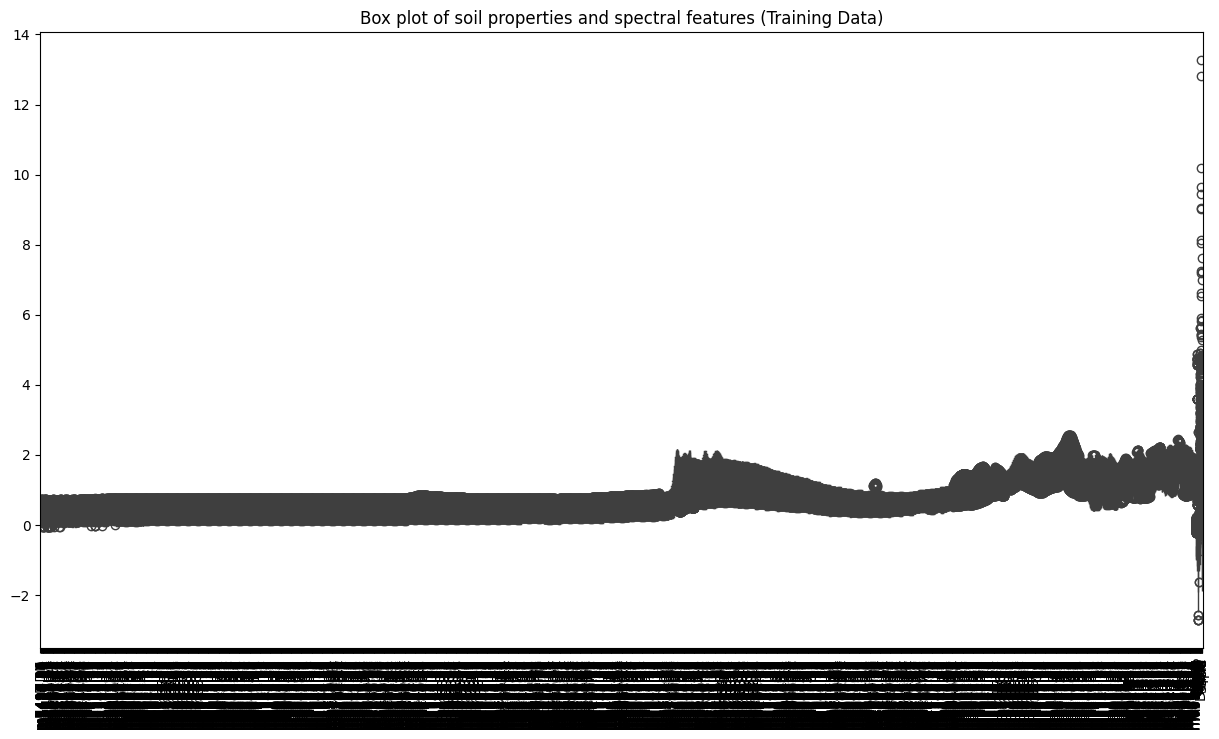

In [13]:
# Box plot for each soil property in training data
plt.figure(figsize=(15, 8))
sns.boxplot(data=train_data.select_dtypes(include=[float, int]))
plt.title("Box plot of soil properties and spectral features (Training Data)")
plt.xticks(rotation=90)
plt.show()


In [14]:
# Calculate z-scores for the training data
z_scores_train = np.abs(stats.zscore(train_data.select_dtypes(include=[float, int])))

# Identify data points with z-scores above the threshold (e.g., 3)
outliers_train = np.where(z_scores_train > 3)

# Output the number of outliers per column
outlier_counts = np.sum(z_scores_train > 3, axis=0)
print("Number of outliers in each column of training data:")
print(outlier_counts)


Number of outliers in each column of training data:
PIDN         0
m7497.96     6
m7496.04     6
m7494.11     6
m7492.18     6
            ..
Ca          26
P           21
pH           1
SOC         28
Sand         0
Length: 3600, dtype: int64


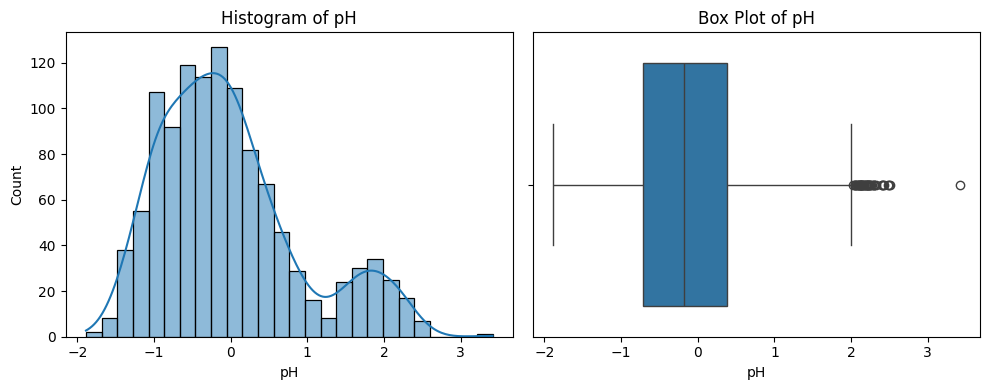

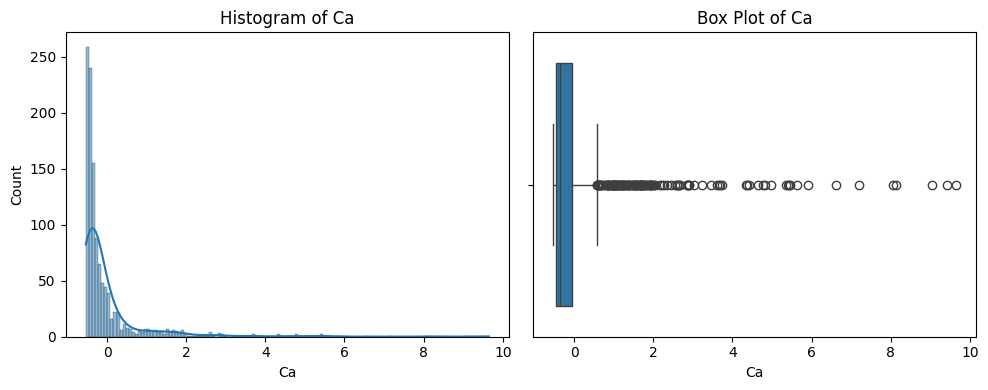

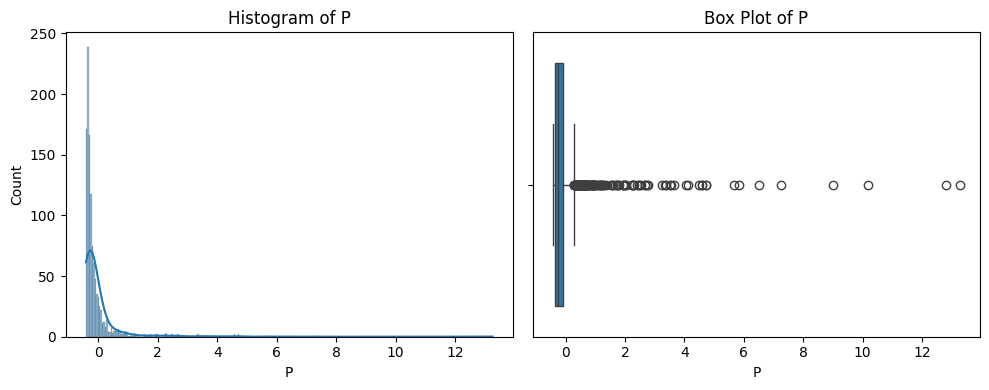

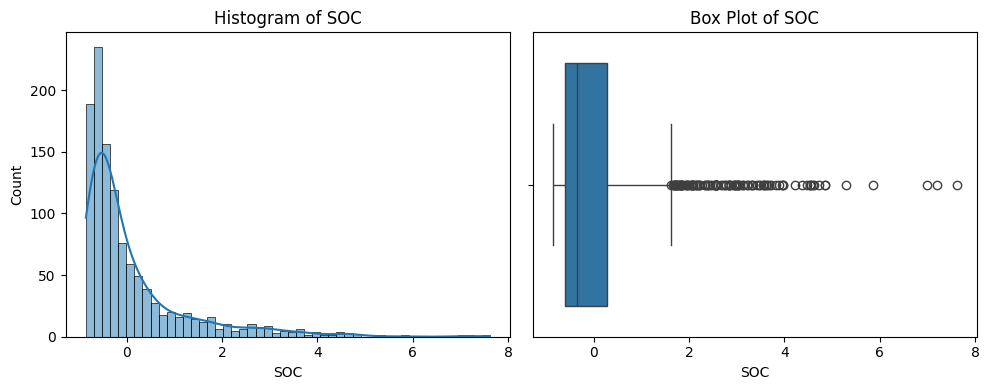

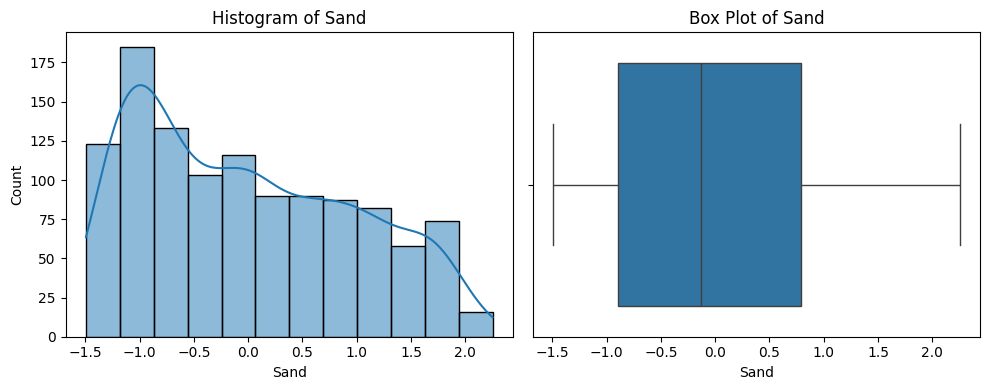

In [16]:
# Assuming soil properties are the last few columns of the train_data
# List of target soil properties
soil_properties = ['pH', 'Ca', 'P', 'SOC', 'Sand']

# Plot distribution for each soil property
for prop in soil_properties:
    plt.figure(figsize=(10, 4))
    
    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[prop], kde=True)
    plt.title(f'Histogram of {prop}')
    
    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_data[prop])
    plt.title(f'Box Plot of {prop}')
    
    plt.tight_layout()
    plt.show()
